# ネットワーク可制御性解析の例
ノードの分類（「不必要」「中立」「不可欠」）とDrug targetの関連性を調査

networkxの読み込み

In [1]:
import networkx as nx

その他ライブラリ

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [3]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 25.3 MB/s eta 0:00:00


In [4]:
import pulp

## 乳がんタンパク質相互作用ネットワークの読み込み
* エッジリスト形式
* 有向ネットワーク
* Kanhaiya K, Czeizler E, Gratie C, Petre I (2017) Controlling directed protein interaction networks in cancer. Sci Rep 7, 10327. doi: [10.1038/s41598-017-10491-y](https://doi.org/10.1038/s41598-017-10491-y)

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/kztakemoto/network-analysis-in-biology/refs/heads/main/data/breast_cancer_directed_ppi_Kanhaiya_etal_2017.csv")

# グラフオブジェクトの作成
g_dir = nx.from_pandas_edgelist(df,
                           source="source",
                           target="target",
                           create_using=nx.DiGraph())  # 有向グラフとして作成

# 多重エッジと自己ループの削除（必須でない）
g_dir = nx.DiGraph(g_dir)  # 多重エッジを自動的に削除
g_dir.remove_edges_from(nx.selfloop_edges(g_dir))  # 自己ループを削除

# 最大強連結成分の取得（本来は不必要だが，小さなネットワークを得るために実行）
g = g_dir.subgraph(max(nx.strongly_connected_components(g_dir), key=len))

## 最大マッチングに基づくネットワーク可制御性に基づくいてノードを分類する
関連する関数を読み込む

In [6]:
def get_mds_matching(g, relax=False):
  # Handle edge weights
  for e in g.edges():
    if 'weight' not in g[e[0]][e[1]]:
        g[e[0]][e[1]]['weight'] = 1.0

  # Handle node names
  mapping = {old: i for i, old in enumerate(g.nodes())}
  g = nx.relabel_nodes(g, mapping)

  # Get edge list and create optimization problem
  edge_list = list(g.edges())
  n_nodes = g.number_of_nodes()
  n_edges = g.number_of_edges()

  # Create LP problem
  prob = pulp.LpProblem("MaximumMatching", pulp.LpMaximize)

  # Decision variables
  if relax:
    x = pulp.LpVariable.dicts("edge", range(n_edges), lowBound=0, upBound=1)
  else:
    x = pulp.LpVariable.dicts("edge", range(n_edges), cat='Binary')

  # Objective function
  prob += pulp.lpSum([x[i] * g[edge_list[i][0]][edge_list[i][1]]['weight'] for i in range(n_edges)])

  # Constraints
  for i in range(n_nodes):
    # Out-degree constraints
    prob += pulp.lpSum([x[j] for j in range(n_edges) if edge_list[j][0] == i]) <= 1
    # In-degree constraints
    prob += pulp.lpSum([x[j] for j in range(n_edges) if edge_list[j][1] == i]) <= 1

  # Solve the problem
  prob.solve()

  # Get matching solution
  matching_links = [round(x[i].value()) for i in range(n_edges)]

  # Find driver nodes
  matched_nodes = set(edge_list[i][1] for i in range(n_edges) if matching_links[i] == 1)
  driver_nodes = [1 if node not in matched_nodes else 0 for node in range(n_nodes)]

  return {
    "minimum driver node set size": sum(driver_nodes),
    "is driver node": driver_nodes,
    "is matching link": matching_links
  }

In [7]:
def node_classification_controllability(g, get_mds=get_mds_matching, relax=False):
  # ノードの分類
  node_class = []
  # 元のグラフでの最小ドライバーノードセットのサイズ
  mds_original = get_mds(g, relax)["minimum driver node set size"]

  # 各ノードについて処理
  for v in g.nodes():
    # ノードvを削除したグラフを作成
    g_del = g.copy()
    g_del.remove_node(v)

    # 削除後のグラフでの最小ドライバーノードセットのサイズ
    mds_del = get_mds(g_del, relax)["minimum driver node set size"]

    # ノードの分類
    if mds_original == mds_del:
        node_class.append("neutral")
    elif mds_original < mds_del:
        node_class.append("indispensable")
    else:  # mds_original > mds_del
        node_class.append("dispensable")

  return node_class

分類

In [8]:
classifications = node_classification_controllability(g, get_mds = get_mds_matching, relax = False)

## 各ノード分類の次数の比較

<ipython-input-9-ca6c64ae3a76>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,


Text(0.5, 1.0, 'Distribution of Node Degrees by Classification')

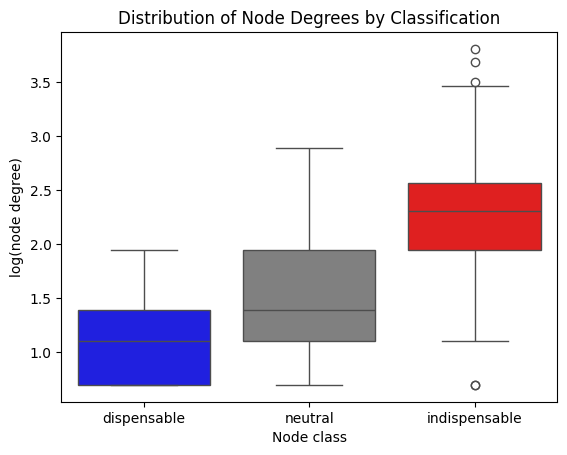

In [9]:
# 次数を取得
degrees = dict(g.degree())
degrees_log = {node: np.log(deg) for node, deg in degrees.items()} # 対数化

# ノードの分類結果とデータをDataFrameに結合
df = pd.DataFrame({
    'node': list(g.nodes()),
    'log_degree': [degrees_log[node] for node in g.nodes()],
    'node_class': classifications  # 前のコードで計算した分類結果
})

# 箱ひげ図の作成
class_colors = {'dispensable': 'blue', 'indispensable': 'red', 'neutral': 'gray'}
sns.boxplot(data=df,
            x='node_class',
            y='log_degree',
            palette=class_colors)

# グラフの設定
plt.xlabel('Node class')
plt.ylabel('log(node degree)')
plt.title('Distribution of Node Degrees by Classification')

## Drug targetのリストを読み込む
アメリカ食品医薬品局が承認した（FDA-approved）薬剤標的タンパク質のリスト

* Kanhaiya K, Czeizler E, Gratie C, Petre I (2017) Controlling directed protein interaction networks in cancer. Sci Rep 7, 10327. doi: [10.1038/s41598-017-10491-y](https://doi.org/10.1038/s41598-017-10491-y)

In [10]:
# 薬剤ターゲットのデータを読み込み
drug_target = pd.read_csv("https://raw.githubusercontent.com/kztakemoto/network-analysis-in-biology/refs/heads/main/data/drug_target_proteins.csv")
# 薬剤ターゲットかどうか
target_attr = {node: "target" if node in drug_target['target'].values else "nontarget" for node in g.nodes()}

## ノードクラスとDrug targetの関連性評価

In [11]:
# ノードの分類とターゲット情報を DataFrame に変換
node_data = pd.DataFrame({
    'node_class': classifications,
    'target': [target_attr[node] for node in g.nodes()]
})

In [12]:
# 混同行列の作成
conf_table = pd.crosstab(node_data['node_class'], node_data['target'])
print("Confusion Table:")
print(conf_table)

Confusion Table:
target         nontarget  target
node_class                      
dispensable           68       4
indispensable         37      16
neutral               63      14


## 各ノードクラスにおけるDrug targetの割合を計算

In [13]:
# 各ノードクラスにおけるDrug targetの割合を計算
target_ratio = conf_table['target'] / conf_table.sum(axis=1)
print("\nTarget Ratios:")
print(target_ratio)


Target Ratios:
node_class
dispensable      0.055556
indispensable    0.301887
neutral          0.181818
dtype: float64


プロット

<BarContainer object of 3 artists>

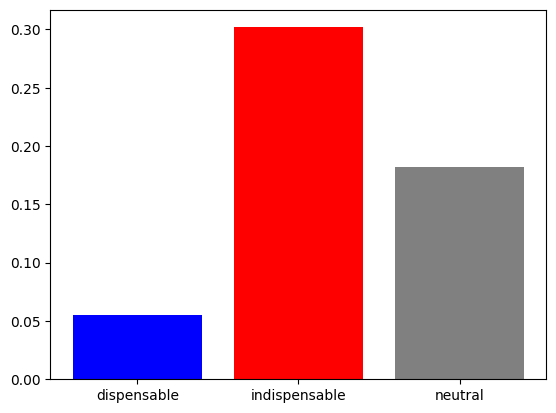

In [14]:
plt.bar(target_ratio.index, target_ratio.values, color=[class_colors[cls] for cls in target_ratio.index])

## 関連性を統計検定（エンリッチメント解析）

In [15]:
# 混同行列からデータを抽出
contingency_table = conf_table.values

# カイ二乗検定
chi2, p_value, dof, expected = stats.chi2_contingency(conf_table)

print("\nChi-square Test for Independence")
print("---------------------------------")
print(f"chi-square statistic: {chi2:.6f}")
print(f"p-value: {p_value:.6f}")
print(f"degrees of freedom: {dof}")


Chi-square Test for Independence
---------------------------------
chi-square statistic: 13.394836
p-value: 0.001234
degrees of freedom: 2


# やってみよう
* このNotebookを参考にして，別の生物ネットワークを解析してみよう（dataに様々ある）。
* `get_mds_matching`（最大マッチングに基づく手法）の代わりに，`get_mds_domination`（最小支配集合に基づく手法）を用いた場合，結果はどうなるでしょうか。
* ノードのクラスと必須タンパク質には関係性があるでしょうか。具体的にどのような傾向があるでしょうか。
* 乳がんにおける必須タンパク質のリスト
  * Kanhaiya K, Czeizler E, Gratie C, Petre I (2017) Controlling directed protein interaction networks in cancer. Sci Rep 7, 10327. doi: [10.1038/s41598-017-10491-y](https://doi.org/10.1038/s41598-017-10491-y)
* Notebookを参考に自分のデータを解析してみよう。